# Imports

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import gc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import pickle 
import matplotlib.pyplot as plt

# from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.tree import plot_tree
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# input_files = []

# for dirname, _, filenames in os.walk('dataset\downsampled'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#         input_files.append(os.path.join(dirname, filename))
input_files = ["dataset/downsampled/final_downsampled_dataset_5050ratio_unlabelled.csv"]
# print(input_files)
# print("\nImports done")

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Cleanup for CSECICIDS2018_improved and CICIDS2017_improved

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
def dataset_cleaner(df, label_column):
    """
    Clean the dataset by handling missing values, scaling numerical features, and 
    applying one-hot encoding to categorical features, while leaving the label class intact.
    
    Parameters:
    - df: DataFrame, the input DataFrame.
    - label_column: str, the name of the target (label) column to be preserved.
    
    Returns:
    - DataFrame with cleaned features and the label column intact.
    """
    
    # Separate label column from features
    label = df[label_column]
    df = df.drop(columns=[label_column])
    
    # Drop all inf and other NaN values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)

    # Define numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # 1. Handle numerical columns (impute missing values and scale)
    if numerical_cols:
        # Imputation for numerical columns
        numerical_imputer = SimpleImputer(strategy='mean')
        df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

        # Scaling numerical columns
        scaler = StandardScaler()
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    if categorical_cols:
        # 2. Handle categorical columns (impute missing values and apply one-hot encoding)
        # Imputation for categorical columns
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])
        
        df = pd.get_dummies(df)
        print("hot enconding done")

    # Re-add the label column
    df[label_column] = label

    return df

def get_target_features(df, test_size = 0.30):
    X = df.drop(['Label'], axis=1)
    y = df['Label']
    
    return train_test_split(X, y, test_size=test_size, random_state=42)

print("Functions defined")

Functions defined


# Feature Selection

In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

def select_features_correlation(X, y, k=10):
    """
    Select top k features based on correlation with the target.

    Parameters:
    - X: DataFrame, the feature matrix.
    - y: Series, the target variable.
    - k: int, number of top features to select.

    Returns:
    - List of top k features based on correlation.
    """
    # Factorize the target and convert to pandas Series
    y_factorized = pd.Series(y.factorize()[0], index=y.index)
    
    # Convert categorical features to numeric
    X_encoded = X.apply(LabelEncoder().fit_transform)
    
    # Compute correlation
    correlation = X_encoded.corrwith(y_factorized)
    
    # Create a DataFrame for correlation values
    correlation_df = pd.DataFrame({
        'Feature': correlation.index,
        'Correlation': correlation.values
    }).sort_values(by='Correlation', key=abs, ascending=False)
    
    # Select top k features
    return correlation_df.head(k)['Feature'].tolist()

def select_features_information_gain(X, y, k=10):
    """
    Select top k features based on information gain with the target.

    Parameters:
    - X: DataFrame, the feature matrix.
    - y: Series, the target variable.
    - k: int, number of top features to select.

    Returns:
    - List of top k features based on information gain.
    """
    # Convert categorical features to numeric
    X_encoded = X.apply(LabelEncoder().fit_transform)
    
    # Calculate information gain
    info_gain = mutual_info_classif(X_encoded, y, discrete_features='auto', random_state=42)
    
    # Create a DataFrame for information gain values
    info_gain_df = pd.DataFrame({
        'Feature': X.columns,
        'Information Gain': info_gain
    }).sort_values(by='Information Gain', ascending=False)
    
    # Select top k features
    return info_gain_df.head(k)['Feature'].tolist()

def get_top_features_across_files(file_paths, label_column, k=10):
    """
    Get top k features across multiple files, based on both correlation and information gain.

    Parameters:
    - file_paths: list of file paths.
    - label_column: name of the label column.
    - k: number of top features to select.

    Returns:
    - List of top k features consistent across all files.
    """
    feature_counter = Counter()
    idx = 1

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        X = df.drop(columns=[label_column])
        y = df[label_column]
        
        # Select top features using both methods
        top_corr_features = select_features_correlation(X, y, k)
        top_ig_features = select_features_information_gain(X, y, k)
        
        # Combine and count features
        feature_counter.update(top_corr_features + top_ig_features)
        print("File "+str(idx)+" done.")
        idx = idx+1
    
    # Get most common features across files
    most_common_features = feature_counter.most_common(k)
    return [feature for feature, _ in most_common_features]

def keep_selected_features(df, selected_features, label_column):
    """
    Keep only the selected features in the given DataFrame, while leaving the label column intact.

    Parameters:
    - df: DataFrame, the input DataFrame.
    - selected_features: list of feature names to keep.
    - label_column: str, the name of the target (label) column to be preserved.

    Returns:
    - DataFrame with only the selected features and the label column.
    """
    # Extract the label column
    label = df[label_column]
    
    # Drop the label column from the selected features if it's included
    if label_column in selected_features:
        selected_features.remove(label_column)
    
    # Keep only the selected features
    updated_df = df[selected_features]
    
    # Re-add the label column
    updated_df[label_column] = label
    
    return updated_df





In [22]:
# top_features = get_top_features_across_files(input_files,'Label',20)
# print(top_features)

In [23]:
top_features = ['Attack', 'TCP_WIN_MAX_IN', 'TCP_FLAGS', 'L7_PROTO', 'MAX_IP_PKT_LEN', 'LONGEST_FLOW_PKT', 'MAX_TTL', 'MIN_TTL', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'CLIENT_TCP_FLAGS', 'PROTOCOL', 'DNS_TTL_ANSWER', 'DNS_QUERY_ID', 'MIN_IP_PKT_LEN', 'DNS_QUERY_TYPE', 'SHORTEST_FLOW_PKT', 'DURATION_OUT', 'DURATION_IN']
top_features.remove('Attack')

# Load each file, do label clean up, run random forest  on it

In [24]:
# we will add to these 3 lists test set and predictions for all csv
# then we will merge them in one pandas object
# then we can do metrics on the dataset as a whole
# pros: will get whole dataset metrics
# cons: the 3 list and merged object may overflow 30 gb ram (praying it wont)
X_test_sets = []
y_test_sets = []

# MODELS
print("Initializing RF model")
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

i = 0

for f in input_files:
    
    i += 1
        
    print(f"{i}/{len(input_files)} CURRENT FILE: {f}\n")
    
    df = pd.read_csv(f)
    
    print(f"LOADED FILE {f}, STARTING CLEANUP\n")

    df = keep_selected_features(df,top_features,'Label') 
    
    df = dataset_cleaner(df,'Label')
    
    
    print(f"CLEANUP DONE, STARTING SPLIT\n")
    
    X_train, X_test, y_train, y_test = get_target_features(df, 0.30)
    
    # no need for df now
    df = None
    gc.collect()
    
    X_test.to_csv(f"test_chunks/{i}X_test.csv", index=False)
    y_test.to_csv(f"test_chunks/{i}y_test.csv", index=False)
    
    # no need for the test sets either
    del X_test
    del y_test
    gc.collect()
    
    print("DONE WRITING TEST SETS TO FILES, STARTING TRAIN\n")
    
    # rf
    print("RUNNING RF MODEL TRAIN...\n")
    
    rf_model.fit(X_train, y_train)
    
    del X_train
    del y_train
    gc.collect()
    
    print(f"RF MODEL TRAINED ON FILE: {f} \n\n")
    

print(f"{i}/{len(input_files)} files worked on\n\n")

# clear memory
df = None
gc.collect()

Initializing RF model
1/1 CURRENT FILE: dataset/downsampled/final_downsampled_dataset_5050ratio_unlabelled.csv

LOADED FILE dataset/downsampled/final_downsampled_dataset_5050ratio_unlabelled.csv, STARTING CLEANUP

CLEANUP DONE, STARTING SPLIT



C:\Users\ahmed\AppData\Local\Temp\ipykernel_9756\1228589077.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_df[label_column] = label


DONE WRITING TEST SETS TO FILES, STARTING TRAIN

RUNNING RF MODEL TRAIN...

RF MODEL TRAINED ON FILE: dataset/downsampled/final_downsampled_dataset_5050ratio_unlabelled.csv 


1/1 files worked on




0

# Prepare outputs for metric calculation

In [25]:
print("READING X TEST SETS AND PREDICTING\n")
gc.collect()

rf_predictions = []
y_tests = []

for curr in range(1,i+1):
    print(f"Reading X_test file {curr}/{i}\n")

    df_X = pd.read_csv(f"test_chunks/{curr}X_test.csv")
    
    print(f"Read {curr}-th X_test file, shape: {df_X.shape}\nPredicting and appending...")
    
    pred = rf_model.predict(df_X)
    rf_predictions.append(pred)
    
    del df_X 
    gc.collect()
    
    print(f"Done reading and predictiong on X_test file {curr}/{i}\n")
    

rf_predictions_joined = np.concatenate(rf_predictions)

# remove prediction list
del rf_predictions
gc.collect()

print("PREDICTION DONE USING RF MODELS: ")
print( rf_predictions_joined.shape)

print("\nREADING y_test FILES\n")

for curr in range(1,i+1):
    print(f"Reading y_test file {curr}/{i}\n")

    df_y = pd.read_csv(f"test_chunks/{curr}y_test.csv")
    
    print(f"Read {curr}-th y_test file, shape: {df_y.shape}\nAppending...")
    
    y_tests.append(df_y)
    
    del df_y
    gc.collect()
    
    print(f"Done reading and adding y_test file {curr}/{i}\n")
    
y_test_sets_joined = pd.concat(y_tests)

# remove y_tests
del y_tests
gc.collect()


print("DONE READING y_test FILES: ")
print(y_test_sets_joined.shape)

READING X TEST SETS AND PREDICTING

Reading X_test file 1/1

Read 1-th X_test file, shape: (10823, 18)
Predicting and appending...
Done reading and predictiong on X_test file 1/1

PREDICTION DONE USING RF MODELS: 
(10823,)

READING y_test FILES

Reading y_test file 1/1

Read 1-th y_test file, shape: (10823, 1)
Appending...
Done reading and adding y_test file 1/1

DONE READING y_test FILES: 
(10823, 1)


# Metrics

In [26]:
rf_accuracy = accuracy_score(y_test_sets_joined, rf_predictions_joined)
rf_f1 = f1_score(y_test_sets_joined, rf_predictions_joined, average='macro')
rf_precision = precision_score(y_test_sets_joined, rf_predictions_joined, average='macro')
rf_recall = recall_score(y_test_sets_joined, rf_predictions_joined, average='macro')

print("rf METRICS: \n")
print(f"ACCURACY: \t {rf_accuracy:.4f}")
print(f"F1 SCORE: \t {rf_f1:.4f}")
print(f"PRECISION: \t {rf_precision:.4f}")
print(f"RECALL: \t {rf_recall:.4f}")

rf METRICS: 

ACCURACY: 	 0.9758
F1 SCORE: 	 0.9758
PRECISION: 	 0.9762
RECALL: 	 0.9757


# Plots

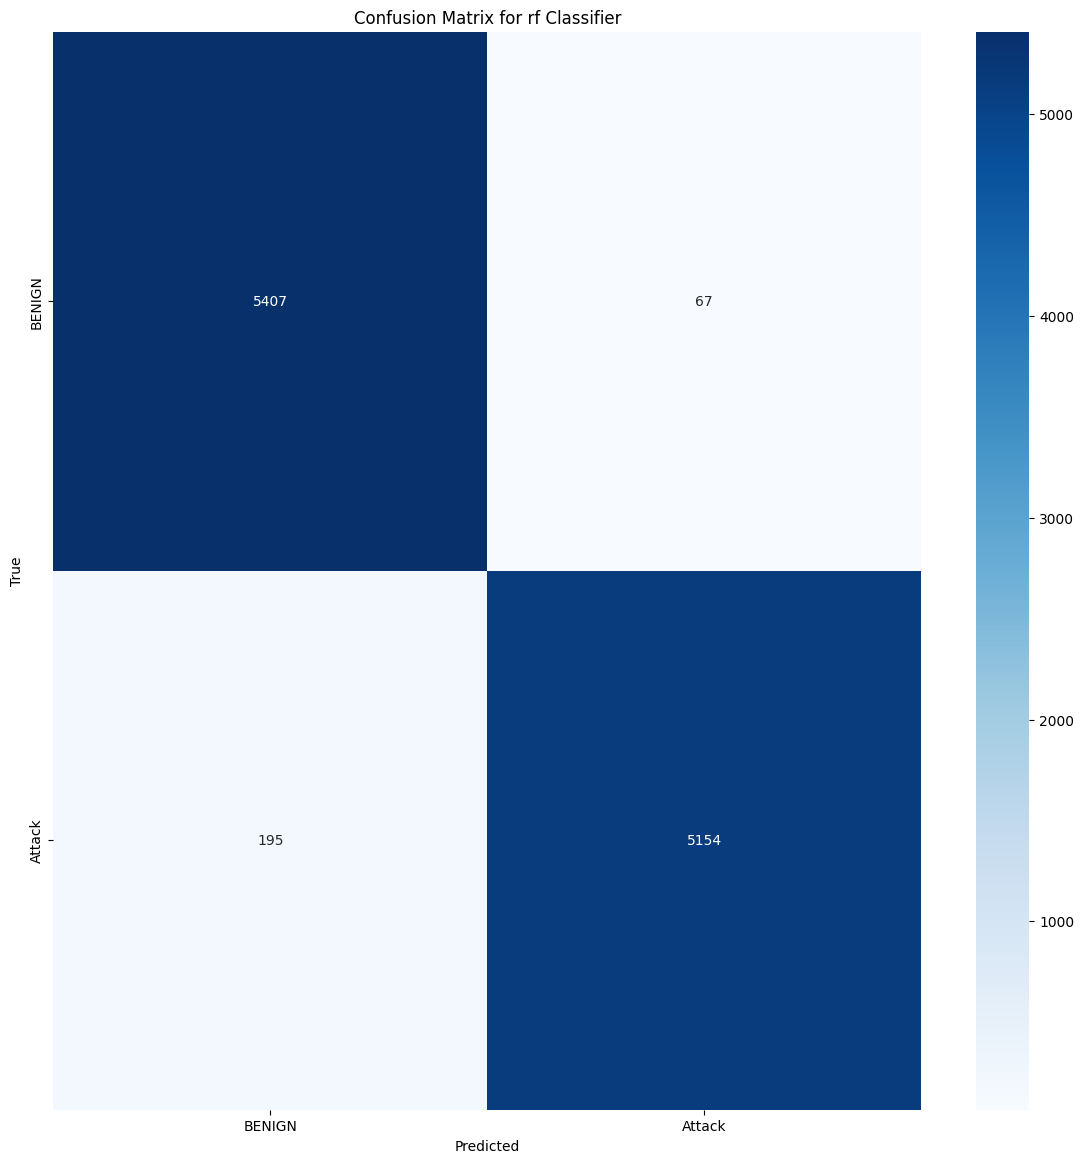

In [27]:
# Confusion Matrix
classes = ["BENIGN", "Attack"]
title = "Confusion Matrix for rf Classifier"

cm = confusion_matrix(y_test_sets_joined, rf_predictions_joined)
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(title)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
def save_model(model, filename="model.pkl"):
    with open(filename, "wb") as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

In [29]:
def load_model(filename="model.pkl"):
    with open(filename, "rb") as file:
        model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return model

In [30]:
# Save to a pickle file            
save_model(rf_model,"models/rf.pickle")

Model saved to models/rf.pickle
